# Fine-Tuning Lab

Welcome to the fine-tuning lab! By the end of this lab, you will have

1. Loaded a pretrained network and ask it for predictions
2. Trained a logistic model on top of a frozen pretrained network to predict cats from dogs
3. Fine-tuned a pretrained network to predict cats from dogs
4. Performed error analysis to get insight into next steps to take

Let's get started!

---

# Pretrained Networks

In this section, we will practice using a pretrained model, in particular `VGGNet`. `VGGNet` won the 2013 [*ImageNet Large Scale Visual Recognition Challenge (ILSVRC)*](http://image-net.org/challenges/LSVRC/2013/). After loading `VGGNet`, we will have it to make predictions on our images. We will then modify it so that it is tailored to the cats vs. dogs dataset.

# Loading a Pre-Trained `VGGNet` in `keras`

![VGGNet](http://machinethink.net/images/vggnet-convolutional-neural-network-iphone/VGGNet@2x.png)

Keras provides a simple and easy way of loading in a pretrained `VGGNet` for us to play around with.

## Tasks

- Instantiate a `keras.applications.VGG16` model with `ImageNet` pretrained weights
- Use `keras.models.Model.summary()` to visualize the architecture

## Hints

- [Documentation](https://keras.io/applications/#vgg16) for `keras.applications.VGG16`
- Check out the example **Extract features with VGG16** on the `keras` [applications](https://keras.io/applications/) page for how to load a `VGG16` model with pretrained `ImageNet` weights

## Notes

- The first time you instantiate a `keras.applications.vgg16.VGG16` with ImageNet weights keras will download the weights which might take some time so be patient!

In [151]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense

vgg16 = VGG16(weights='imagenet')

In [152]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Task

- Download the file `CatsVDogs.p` and put it in an accessible directory and load the data into memory

In [153]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from IPython.display import display
import numpy as np
import pickle

In [154]:
[imgs, y] = pickle.load(open('CatsVDogs.p', 'rb'))

In [155]:
len(imgs), y.shape

(2000, (2000,))

In [156]:
imgs[:5]

[<PIL.Image.Image image mode=RGB size=224x224 at 0x11753EBA8>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1143A6518>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1143A60F0>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1143A6A58>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1143A6B70>]

# Preprocessing Images

Even though the cats vs. dogs dataset has different labels than those found in `ImageNet`, we can still ask `VGGNet` to make predictions and output the most likely `ImageNet` classes. But before doing this, we need to perform the necessary preprocessing the VGGNet expects.

### Tasks

- Convert `imgs` to a `4D` `numpy` array and save it to a variable named `X`
- Perform the preprocessing on `X` that `VGGNet16` expects
- Display five prepocessed images

### Hints

- Use `keras.applications.vgg16.preprocess_input()` to zero-center a 4D tensor of images with respect to the mean RGB value in `ImageNet`

In [157]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img

In [158]:
X = np.array([img_to_array(img) for img in imgs])
X = preprocess_input(X)

In [159]:
X.shape, type(X)

((2000, 224, 224, 3), numpy.ndarray)

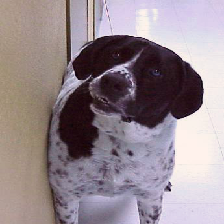

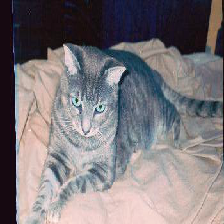

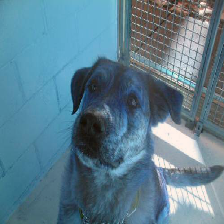

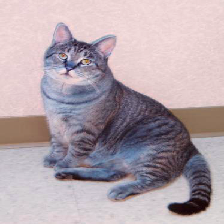

In [160]:
for i in range(0,4):
    img = array_to_img(X[i])
    display(img)

## Question

- What does `keras.applications.vgg16.preprocess_input()` do?

## Hint

- Look at how and where [`keras.applications.vgg16.preprocess_input()`](https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py#L27) is defined

## Answer

- The color channels are shifted and then the mean pixel intensity is subtracted channel-wise.

# `VGGNet` Predictions

Let's make some predictions with our VGGNet.

## Tasks

- Use `keras.applications.vgg16.predict()` to make predictions on the first four images of `X`
- Use `keras.applications.vgg16.decode_predictions()` to recover the object class names from the `VGGNet` predictions
- Display the first four images along with `VGGNet`'s predictions

## Hints

- Look at the `keras` [applications](https://keras.io/applications/) page for an example of making predictions with `VGGNet`

In [161]:
features = vgg16.predict(X[:4])

In [162]:
type(features)

numpy.ndarray

In [163]:
print('Predicted:') 
decode_predictions(features, top=4)[0]

Predicted:


[('n02100236', 'German_short-haired_pointer', 0.97216022),
 ('n02102040', 'English_springer', 0.0072719832),
 ('n02088632', 'bluetick', 0.0050618201),
 ('n02101388', 'Brittany_spaniel', 0.0030717221)]

We see that `VGGNet` does a fairly good job at predicting sensibly classes. However, a lot of modeling effort is wasted by predicting probabilities for 1,000 classes when all we care about are *two* classes (i.e. cat and dog). In other words, `VGGNet` is not tailored to our specific dataset.

# Training a Classifier with `VGGNet` Features

Let's tailor `VGGNet` to the cats vs. dogs dataset by treating `VGGNet` as a black-box feature extractor train a logistic classifier on top.

### Tasks

- Replace the 1000-unit Dense+Softmax layer on `keras.applications.vgg16` with a `1`-unit Dense+Sigmoid layer
- Use `keras.models.Model.summary()` to ensure that you've successfully replaced the `1,000`-way softmax layer with a dense layer followed by a sigmoid activation

### Hints

- Look at the **Fine-tune InceptionV3 on a new set of classes** example on the `keras` [applications](https://keras.io/applications/) page for an example of how to modify the final layers of a `keras.models.Model`

In [164]:
import pandas as pd

In [165]:
fc2 = vgg16.get_layer('fc2').output
p = Dense(units=1, activation='sigmoid', name='logit')(fc2)
model = Model(input=vgg16.input, output=p)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/Users/srianant/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("lo...)`
  '` call to the Keras 2 API: ' + signature)


# Freeze Base Model

We want to treat `VGGNet` as a fixed feature extractor and optimize only the weights in the final Dense layer.

## Tasks

- Set the `trainable` attribute on every `keras.layers.Layer` to `False` for every layer except the last dense layer in the `keras.models.Model`
- Print out the name of each `keras.layers.Layer` with the value of its `trainable` attribute to ensure you've been successful

## Hints

- The `keras.models.Model.layers` attribute provides access the layers in a `keras` model
- The `keras.layers.Layer.name` attribute contains the name of a layer
- `keras.layers.Layer.trainable = False` freezes that layer during training

## Reminder

- Make sure to compile your model after freezing weights for it to really take effect!

In [166]:
# Freez Layers other than last 3-layers fc1, fc2 and logit
for layer in model.layers:
    if layer.name in ['fc1', 'fc2', 'logit']:
        continue
    layer.trainable = False
    
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"white" if trainable else "lightblue"}', subset=['trainable'])

# Train Dense Layer on Cats vs. Dogs Dataset

It's time we learn the parameters of our newly defined dense layer on the cats vs. dogs dataset!

## Tasks

- Compile the `keras.models.Model`
- Call `keras.models.Model.fit()` with the images and labels for 1 epoch and with a `validation_split=0.1`

## Suggestions

- Kill the training after it finishes the first batch (otherwise it will take forever and our concern here is not overall accuracy but learning)

In [172]:
from sklearn.model_selection import train_test_split

In [167]:
from keras.optimizers import SGD

sgd = SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [168]:
import keras
class TrainingVisualizerCallback(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame(self.history).plot()
        plt.show()

In [174]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1500, 224, 224, 3), (1500,), (500, 224, 224, 3), (500,))

In [175]:
model.fit(X_train, y_train, epochs=5, validation_split=0.1, callbacks=[TrainingVisualizerCallback()])

Train on 1350 samples, validate on 150 samples
Epoch 1/5
  32/1350 [..............................] - ETA: 2737s - loss: 0.1063 - acc: 0.9688

KeyboardInterrupt: 

# Make Predictions

Given a new image, the `keras.models.Model` should now output a single number $p(y = \text{dog}\ |\ x)$.

## Tasks

- Use `keras.models.Model.predict()` on the first four images of `X_tf`
- Display the images along with their predictions

In [176]:
model.predict(X_test[:4])

array([[  4.58646362e-04],
       [  7.25626111e-01],
       [  1.16597619e-02],
       [  4.02196683e-02]], dtype=float32)

In [148]:
%matplotlib inline
from matplotlib import pyplot as plt

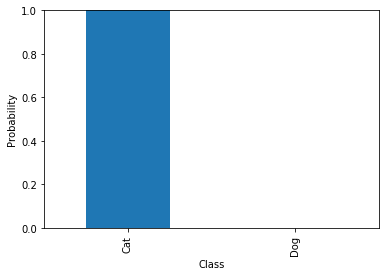

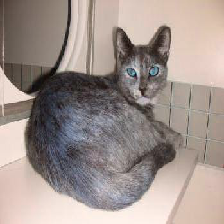

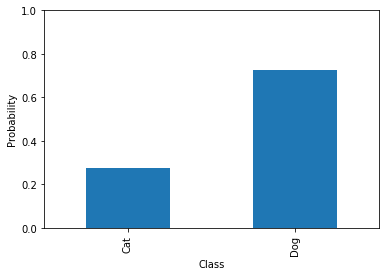

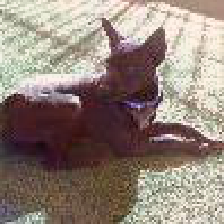

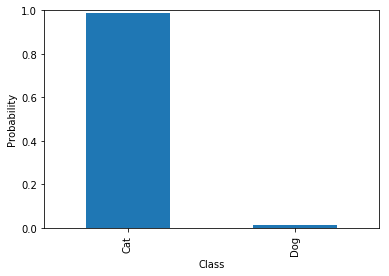

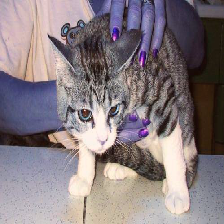

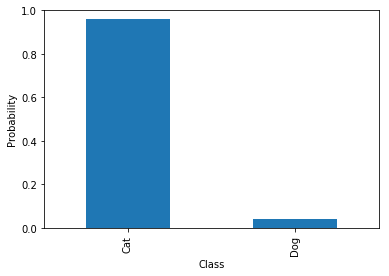

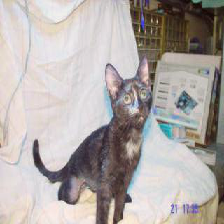

In [177]:
y_pred = model.predict(X_test[:4])

nb_sample = 4
for x, y in zip(X_test[:nb_sample], y_pred.flatten()[:nb_sample]):
    s = pd.Series({'Cat': 1-y, 'Dog': y})
    axes = s.plot(kind='bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Probability')
    axes.set_ylim([0, 1])
    plt.show()

    img = array_to_img(x)
    display(img)

Using `VGGNet` as a black-box feature extractor gets us respectible performance. However, we can do better by leveraging supervised *fine-tuning*, a type of *transfer learning*.

# Fine-Tuning `VGGNet` on Cats vs. Dogs Dataset

In addition to learning the final Dense+Sigmoid layer, we can also update the last few layers of `VGGNet` during training through a process called *fine-tuning*. This process is illustrated in the following figure.

![Fine-Tuning](https://blog.keras.io/img/imgclf/vgg16_modified.png)

# Set Up `VGGNet` for Fine-Tuning

## Tasks

- Unfreeze the penultimate dense layer along with the final conv block
- Print out each layer name with the value of its `trainable` attribute to ensure you've successfully unfrozen the last conv block plus the final two dense layers

## Hints

- Use `keras.models.Model.summary()` to determine the names for the last two `Dense` layers
- Use `keras.models.Model.get_layer()` to get references to these layers
- `keras.layers.Layer.trainable = True` unfreezes a `keras.layers.Layer`

In [178]:
model3 = Model(input=model.input, output=p)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/Users/srianant/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("lo...)`
  '` call to the Keras 2 API: ' + signature)


In [179]:
for layer in model3.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'logit']:
        layer.trainable=True
    else:
        layer.trainable = False
pd.DataFrame(([layer.name, layer.trainable] for layer in model3.layers), columns=['layer', 'trainable'])

,layer,trainable
0,input_3,False
1,block1_conv1,False
2,block1_conv2,False
3,block1_pool,False
4,block2_conv1,False
5,block2_conv2,False
6,block2_pool,False
7,block3_conv1,False
8,block3_conv2,False
9,block3_conv3,False


# Fine-Tune `VGGNet`

Now that we have unfrozen the last two `Dense` layers and the final conv block we can optimize these weights for even better performance.

## Tasks

- `keras.models.Model.compile()` the model with a stochastic gradient descent optimizer with a small learning rate (e.g. $10^{-4}$)
- `keras.models.Model.fit()` the `keras.models.Model` to the image data with a `validation_split=1` for one epoch

## Suggestions

- Kill the training after a minibatch update since it takes forever on a CPU

In [180]:
sgd = SGD(lr=1e-4, momentum=0.9)
model3.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
model3.fit(X_train, y_train, batch_size=32, epochs=1, verbose=True, validation_split=1)

Epoch 1/1
  32/1500 [..............................] - ETA: 2956s - loss: 0.1767 - acc: 0.9062

KeyboardInterrupt: 

### Make Predictions with Fine-Tuned `VGGNet`

### Tasks

- `keras.applications.vgg16.predict()` the labels of the first four images in the cats vs. dogs dataset
- `IPython.display.display()` each image with its prediction

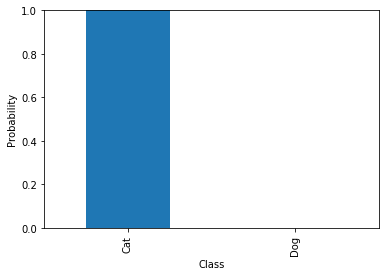

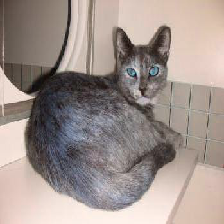

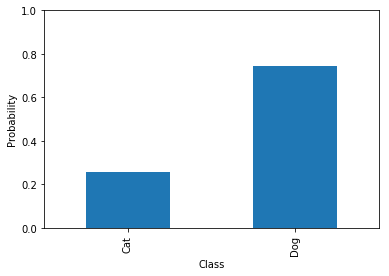

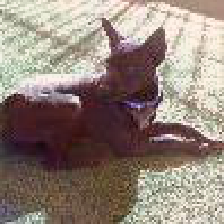

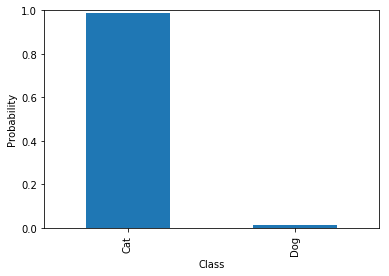

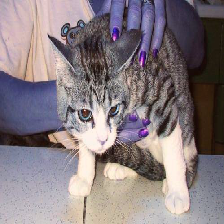

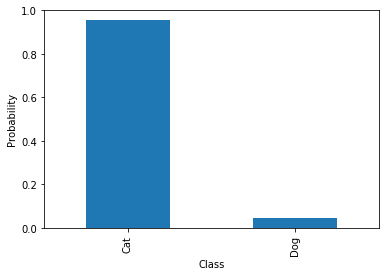

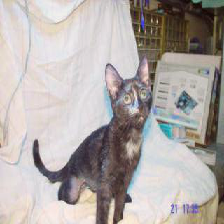

In [185]:
y_pred3 = model3.predict(X_test[:4])

nb_sample = 4
for x, y in zip(X_test[:nb_sample], y_pred3.flatten()[:nb_sample]):
    s = pd.Series({'Cat': 1-y, 'Dog': y})
    axes = s.plot(kind='bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Probability')
    axes.set_ylim([0, 1])
    plt.show()

    img = array_to_img(x)
    display(img)

# Bonus Activities

---

# Error Analysis

Now that we have a reasonably performing image classifier, what's next? A good idea is to perform *error analysis* to systemtically discover which types of errors your model is making the most.

## Task

- Make predictions on the first 128 images

## Hint

- Recall that cats have labels of `0`, while dogs have labels of `1`

## Admission

- In a real-world setting you would make predictions on a held-out test set. However, we have not gone through the trouble of creating one and hence using the training set will do this one time.

In [182]:
predictions4 = model3.predict(X_test[:128])

In [183]:
y_pred4 = predictions4.flatten()
y_pred4[:5]

array([  5.03580086e-04,   7.44526327e-01,   1.27587495e-02,
         4.41652425e-02,   9.67486918e-01], dtype=float32)

In [184]:
y_test128 = y_test[:128]
y_test128[:5]

array([0, 1, 0, 0, 1], dtype=uint64)

## Task

- Display five images which your model made the correct prediction

In [186]:
def predict(row):
    if (row['Predicted'] > 0.5) & (row['Actual'] == 1):
        return True
    elif (row['Predicted'] < 0.5) & (row['Actual'] == 0):
        return True
    else:
        return False


df = pd.DataFrame([y_test128, y_pred]).T
df.columns = ['Actual', 'Predicted']
df['Correct'] = df.apply(predict, axis=1)
df.head()

,Actual,Predicted,Correct
0,0,[0.000458646],True
1,1,[0.725626],True
2,0,[0.0116598],True
3,0,[0.0402197],True
4,1,NaN,False


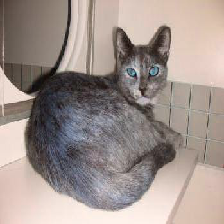

Predicted [ 0.00045865]
Correct True


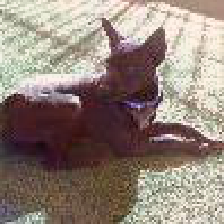

Predicted [ 0.72562611]
Correct True


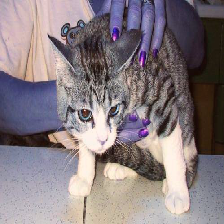

Predicted [ 0.01165976]
Correct True


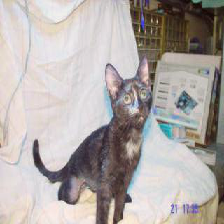

Predicted [ 0.04021967]
Correct True


In [188]:
find_correct = df[df.Correct == True].index[:5].tolist()
for img_ in find_correct:
    i = X_test[img_]
    im = array_to_img(i)
    display(im)
    print('Predicted', df.loc[img_]['Predicted'])
    print('Correct', df.loc[img_]['Correct'])

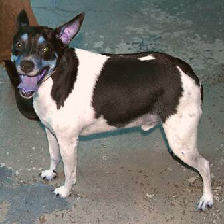

Predicted nan
Correct False


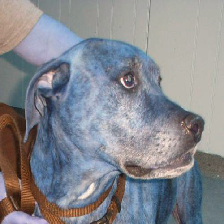

Predicted nan
Correct False


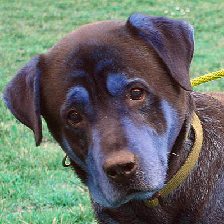

Predicted nan
Correct False


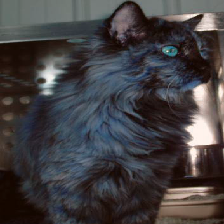

Predicted nan
Correct False


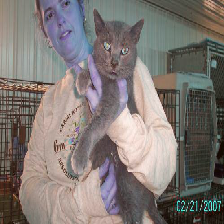

Predicted nan
Correct False


In [187]:
find_incorrect = df[df.Correct == False].index[:5].tolist()
for img_ in find_incorrect:
    i = X_test[img_]
    im = array_to_img(i)
    display(im)
    print('Predicted', df.loc[img_]['Predicted'])
    print('Correct', df.loc[img_]['Correct'])

## Task

- Display five images which your model made an incorrect prediction

## Task

- Display the top five cat images that your model is very sure contains a cat along with its confidence for each image

## Task

- Display the top five cat images that your model is very sure contains a dog along with its confidence for each image

## Task

- Display the top five images which confuse your model the most along with its confidence for each image